In this lecture, we will learn some vary basic concepts related to statistical models.

- [A toy data set](#A-toy-data-set)
- [A single model](#A-single-model)
- [Several models chosen at random](#Several-models-chosen-at-random)
- [Distance between model and data](#Distance-between-model-and-data)
- [Visualizing models](#Visualizing-models)
- [Several models using a grid](#Several-models-using-a-grid)


# A toy data set

In [1]:
library(tidyverse)

library(modelr) # wrapper around base R modeling functions so that they work with the pipe
options(na.action = na.warn) # so that missing values are not silently dropped by modeling functions

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



We will use a toy simulated data set `sim1`

In [2]:
head(sim1)

x,y
<int>,<dbl>
1,4.199913
1,7.510634
1,2.125473
2,8.988857
2,10.243105
2,11.296823


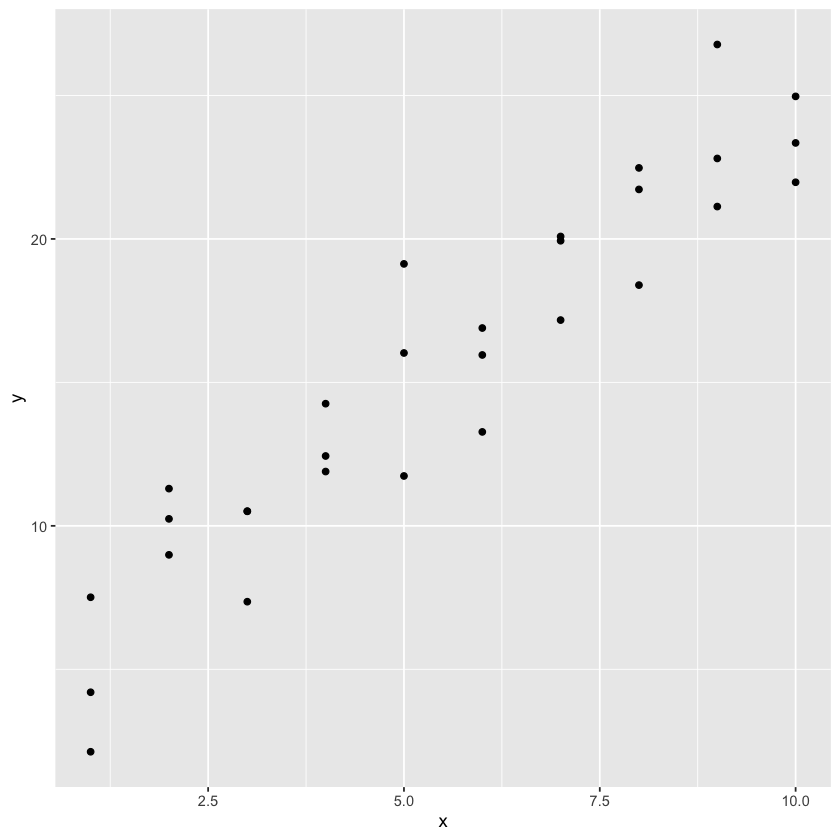

In [3]:
ggplot(sim1) +
    geom_point(aes(x, y))

# A single model

In [4]:
(a0 = runif(1, 1, 10))

[1] 7.820935

In [5]:
(a1 = runif(1, -5, 5))

[1] -1.621905

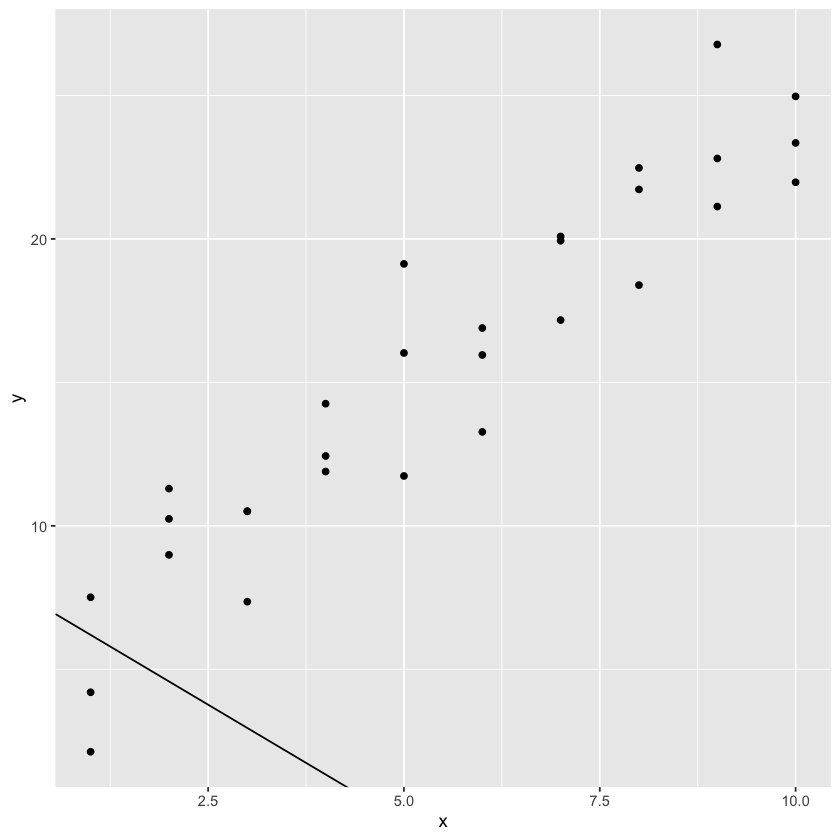

In [6]:
ggplot(sim1) +
    geom_point(aes(x, y)) +
    geom_abline(intercept=a0, slope=a1) # plots the line y = a0 + a1 * x

# Several models chosen at random

We are using a model of the form y = a0 + a1 * x. We have picked a random model from this family. Is it a good model for the data?

Let's try more models. In fact let's try 200 of them!

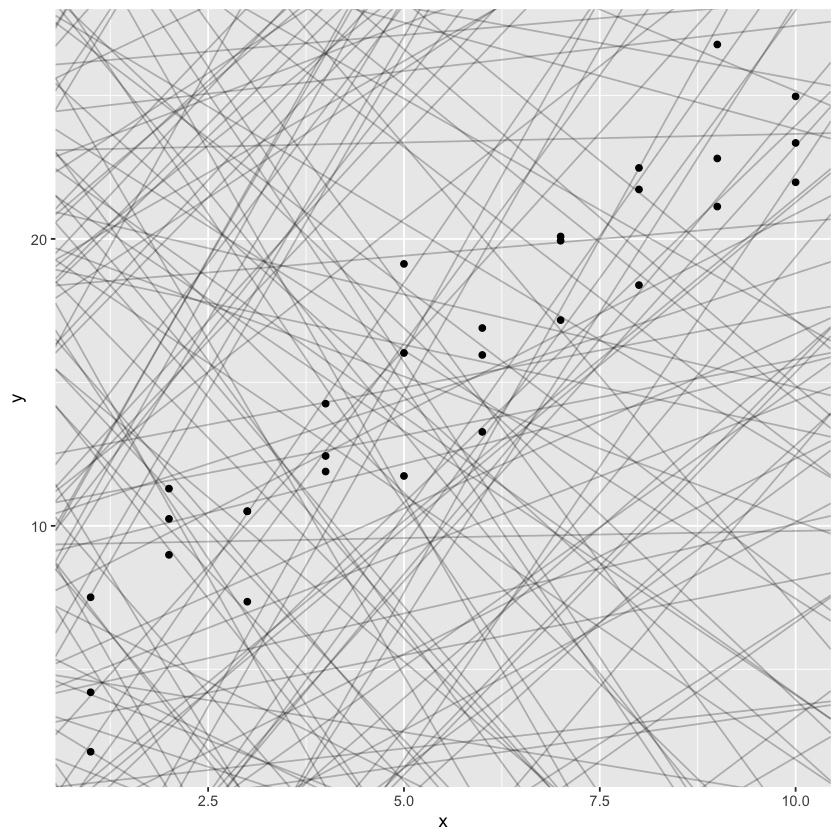

In [7]:
models <- tibble(
  a1 = runif(200, -20, 40),
  a2 = runif(200, -5, 5)
)

ggplot(sim1, aes(x, y)) + 
  geom_abline(aes(intercept = a1, slope = a2), data = models, alpha = 1/4) +
  geom_point() 

In [8]:
model_predictions <- function(model, data) {
    model[1] + data$x * model[2]
}

In [9]:
model_predictions(c(4, 3), sim1)

[1]  7  7  7 10 10 10 13 13 13 16 16 16 19 19 19 22 22 22 25 25 25 28 28 28 31
[26] 31 31 34 34 34

In [10]:
sim1$y

[1]  4.199913  7.510634  2.125473  8.988857 10.243105 11.296823  7.356365
 [8] 10.505349 10.511601 12.434589 11.892601 14.257964 19.130050 11.738021
[15] 16.024854 13.273977 15.955975 16.894796 20.085993 17.171850 19.936309
[22] 21.725903 18.390913 22.475553 26.777010 22.805110 21.128305 24.968099
[29] 23.346422 21.975201

# Distance between model and data

In [11]:
measure_distance <- function(model, data) {
    predictions <- model_predictions(model, data)
    diff <- data$y - predictions
    sqrt(mean(diff ^ 2))
}

In [12]:
intercept = 4
slope = 3
measure_distance(c(intercept, slope), sim1)

[1] 6.075216

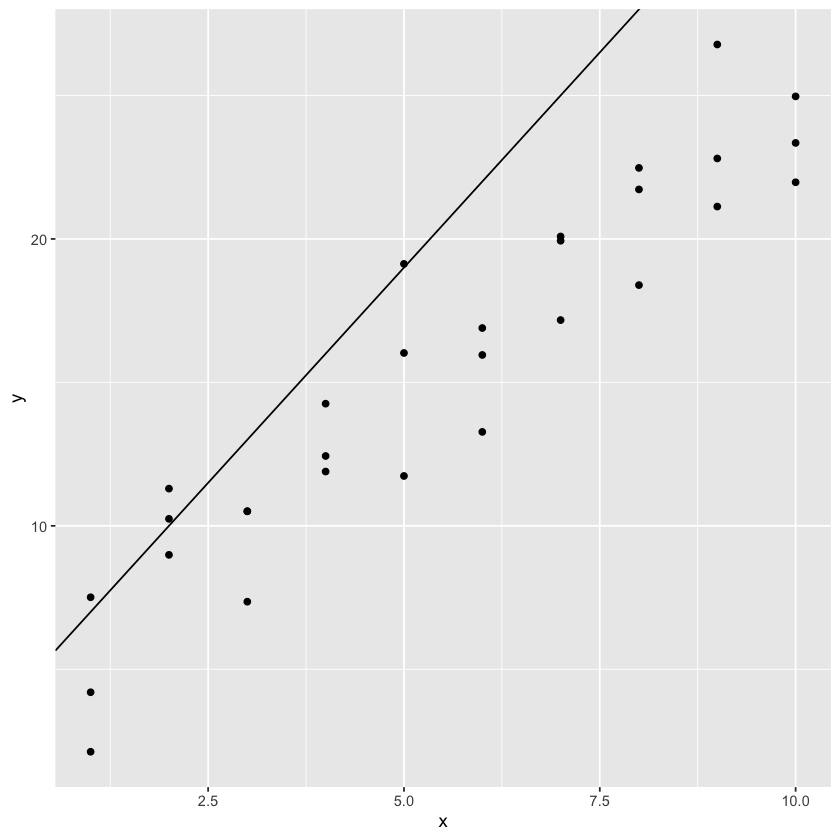

In [13]:
ggplot(sim1) +
    geom_point(aes(x, y)) +
    geom_abline(intercept=intercept, slope=slope)

In [14]:
sim1_dist <- function(a1, a2) {
  measure_distance(c(a1, a2), sim1)
}

models <- models %>% 
  mutate(dist = map2_dbl(a1, a2, sim1_dist))
top_n(models, 5, -dist) # top 5 models (models with least dist values)

a1,a2,dist
<dbl>,<dbl>,<dbl>
-2.343774,2.6295952,4.329652
1.056237,3.0183055,4.107793
6.980720,1.3897237,2.986148
-1.081108,2.2512348,4.746385
9.943415,0.8863182,4.025060


Let's look at the 5 best models

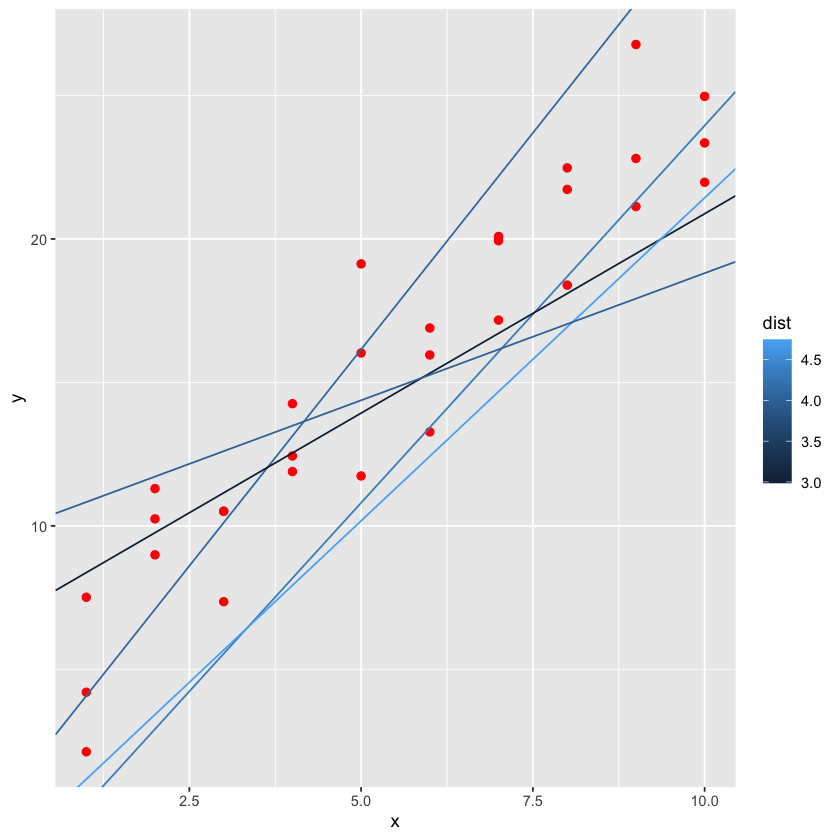

In [15]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, color = "red") + 
  geom_abline(
    aes(intercept = a1, slope = a2, color = dist), 
    data = top_n(models, 5, -dist)
  )

# Visualizing models

Let us now visualize the models themselves. After all the intercepts and slopes are themselves data!

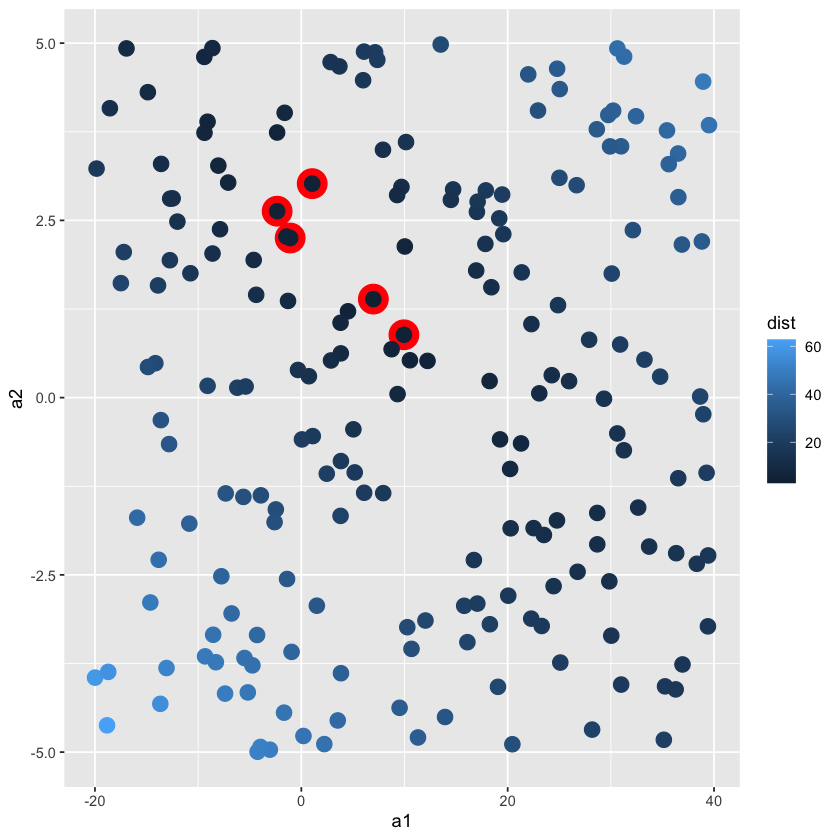

In [16]:
ggplot() +
    geom_point(data = top_n(models, 5, -dist), aes(x = a1, y = a2), size = 8, color = "red") +
    geom_point(data = models, aes(x = a1, y = a2, color = dist), size = 4) 

This tells us where the good models lie in model space. Good values of intercept are in the 0 to 10 range. Good values of slope are in the 1 to 2.5 range. Let us explore this space more systematically by creating a uniform grid of values.

# Several models using a grid

In [17]:
intercept_values <- seq(0, 10, length = 20)
m <- length(intercept_values)

slope_values <- seq(1, 2.5, length = 20)
n <- length(slope_values)

models2 <- tibble(a1 = seq(0,0, length = m*n), a2 = 0)
print(models2)

# A tibble: 400 x 2
      a1    a2
   <dbl> <dbl>
 1     0     0
 2     0     0
 3     0     0
 4     0     0
 5     0     0
 6     0     0
 7     0     0
 8     0     0
 9     0     0
10     0     0
# … with 390 more rows


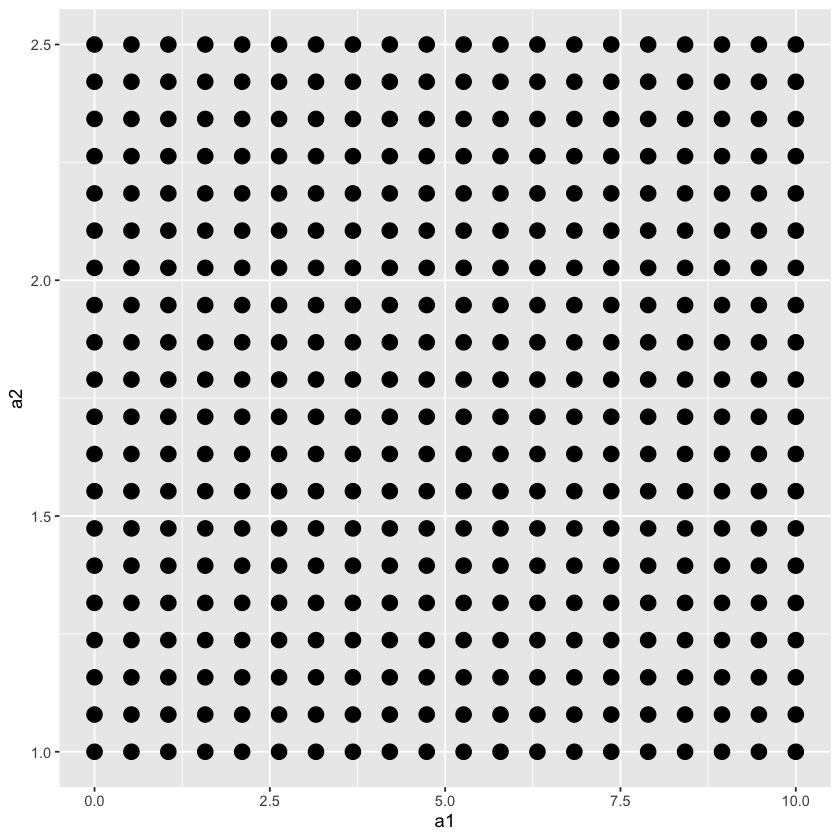

In [18]:
for (x in 1:m) {
    for (y in 1:n) {
        models2[(x-1)*n+y, 1] <- intercept_values[x]
        models2[(x-1)*n+y, 2] <- slope_values[y]
    }
}

ggplot() +
    geom_point(data = models2, aes(x = a1, y = a2), size = 4) 

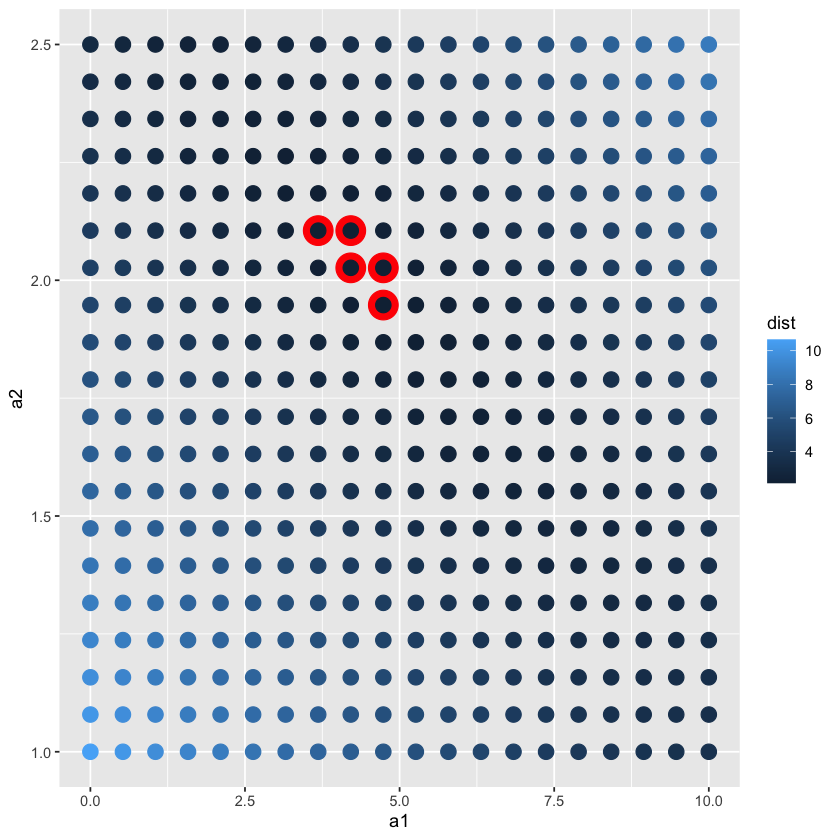

In [19]:
models2 <- mutate(models2, dist = map2_dbl(a1, a2, sim1_dist)) # compute distances of models to sim2 data

ggplot() +
    geom_point(data = top_n(models2, 5, -dist), aes(x = a1, y = a2), size = 8, color = "red") +
    geom_point(data = models2, aes(x = a1, y = a2, color = dist), size = 4) 

Let's look back at these best 5 models in the original data space

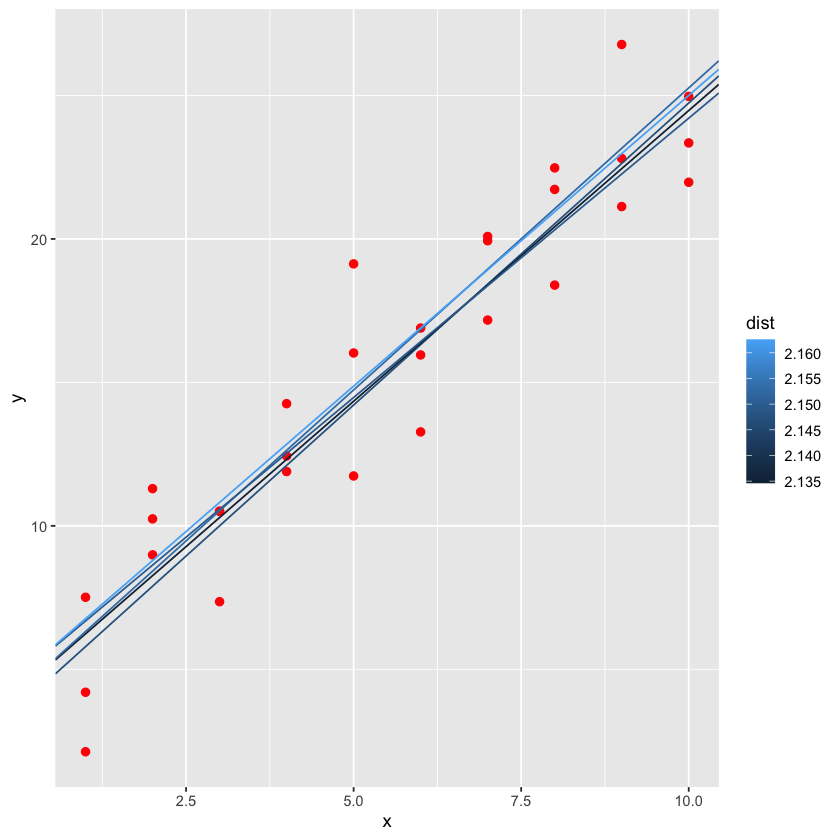

In [20]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, color = "red") + 
  geom_abline(
    aes(intercept = a1, slope = a2, color = dist), 
    data = top_n(models2, 5, -dist)
  )

The best 5 models are as follows.

In [21]:
top_n(models2, 5, -dist)

a1,a2,dist
<dbl>,<dbl>,<dbl>
3.684211,2.105263,2.147347
4.210526,2.026316,2.134619
4.210526,2.105263,2.152747
4.736842,1.947368,2.149861
4.736842,2.026316,2.162585


The model fitting function `lm` does essentially the same thing.

In [22]:
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)

(Intercept)           x 
   4.220822    2.051533

`geom_smooth()` using formula 'y ~ x'



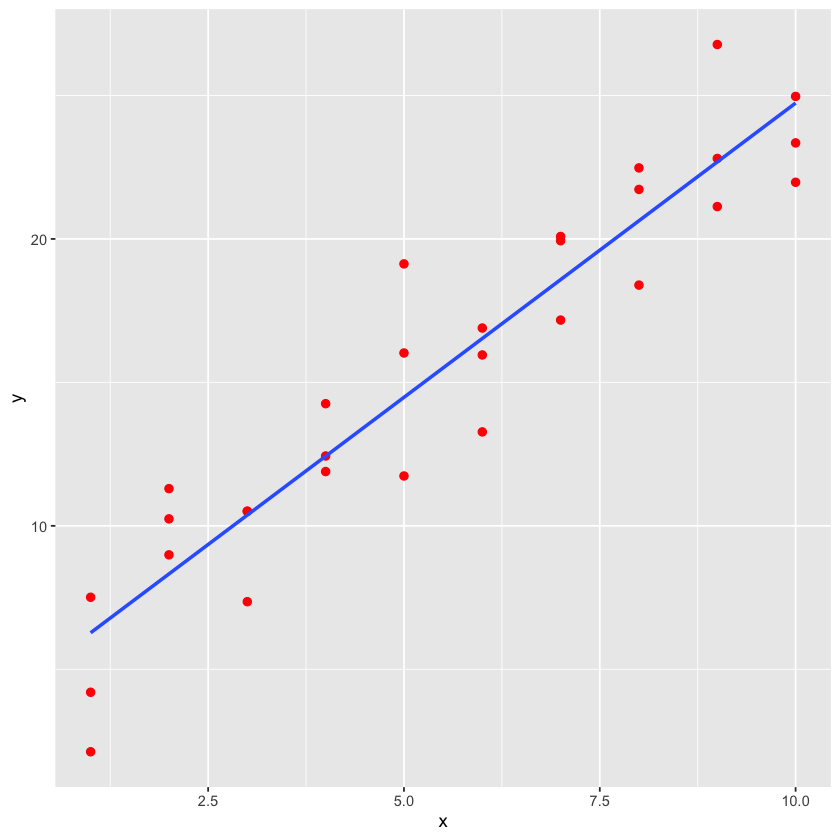

In [23]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, color = "red") + 
  geom_smooth(method = "lm", se=FALSE)